<a href="https://colab.research.google.com/github/enigma5387/Assignments/blob/main/potato_leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [61]:
!kaggle datasets download -d hafiznouman786/potato-plant-diseases-data

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
License(s): CC0-1.0
potato-plant-diseases-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [62]:
import zipfile
zip_ref = zipfile.ZipFile('/content/potato-plant-diseases-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [63]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,layers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [64]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [65]:
dataset = keras.utils.image_dataset_from_directory(
    '/content/PotatoPlants',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [66]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [67]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [68]:
import os
os.listdir("/content/PotatoPlants")

['Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy']

In [69]:
import random
random.sample(os.listdir("/content/PotatoPlants/Potato___Early_blight"),5)

['34d62dee-797e-4f31-9063-f6a285935b4d___RS_Early.B 6733.JPG',
 '66642302-1334-4c23-8613-f98387352360___RS_Early.B 8766.JPG',
 '5fbff81d-eeaf-430f-ba94-df6a92c7b8e2___RS_Early.B 6816.JPG',
 '221c911f-e483-407c-b672-21150d09d57e___RS_Early.B 7678.JPG',
 'f15637d3-829d-46f9-b45e-1e1768d6b8c9___RS_Early.B 7635.JPG']

In [70]:
image = "/content/PotatoPlants/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG"
import cv2
from PIL import Image
img = cv2.imread(image)
#if the image is loaded successfully , print hte its pixel value
if img is not None:
  print(img)
  print(img.shape)
else:
  print("Image not found")

[[[114  97  94]
  [143 126 123]
  [149 132 129]
  ...
  [188 169 161]
  [190 171 163]
  [192 173 165]]

 [[136 119 116]
  [125 108 105]
  [135 118 115]
  ...
  [195 176 168]
  [194 175 167]
  [193 174 166]]

 [[129 112 109]
  [118 101  98]
  [162 145 142]
  ...
  [193 174 166]
  [189 170 162]
  [187 168 160]]

 ...

 [[169 149 144]
  [163 143 138]
  [161 141 136]
  ...
  [203 184 176]
  [205 186 178]
  [207 188 180]]

 [[161 141 136]
  [150 130 125]
  [156 136 131]
  ...
  [206 187 179]
  [205 186 178]
  [205 186 178]]

 [[149 129 124]
  [139 119 114]
  [154 134 129]
  ...
  [200 181 173]
  [198 179 171]
  [196 177 169]]]
(256, 256, 3)


In [71]:
Early_bright = os.listdir("/content/PotatoPlants/Potato___Early_blight")
Late_blight = os.listdir("/content/PotatoPlants/Potato___Late_blight")
Healthy = os.listdir("/content/PotatoPlants/Potato___healthy")
count=[len(Early_bright),len(Late_blight),len(Healthy)]
print(count)

[1000, 1000, 152]


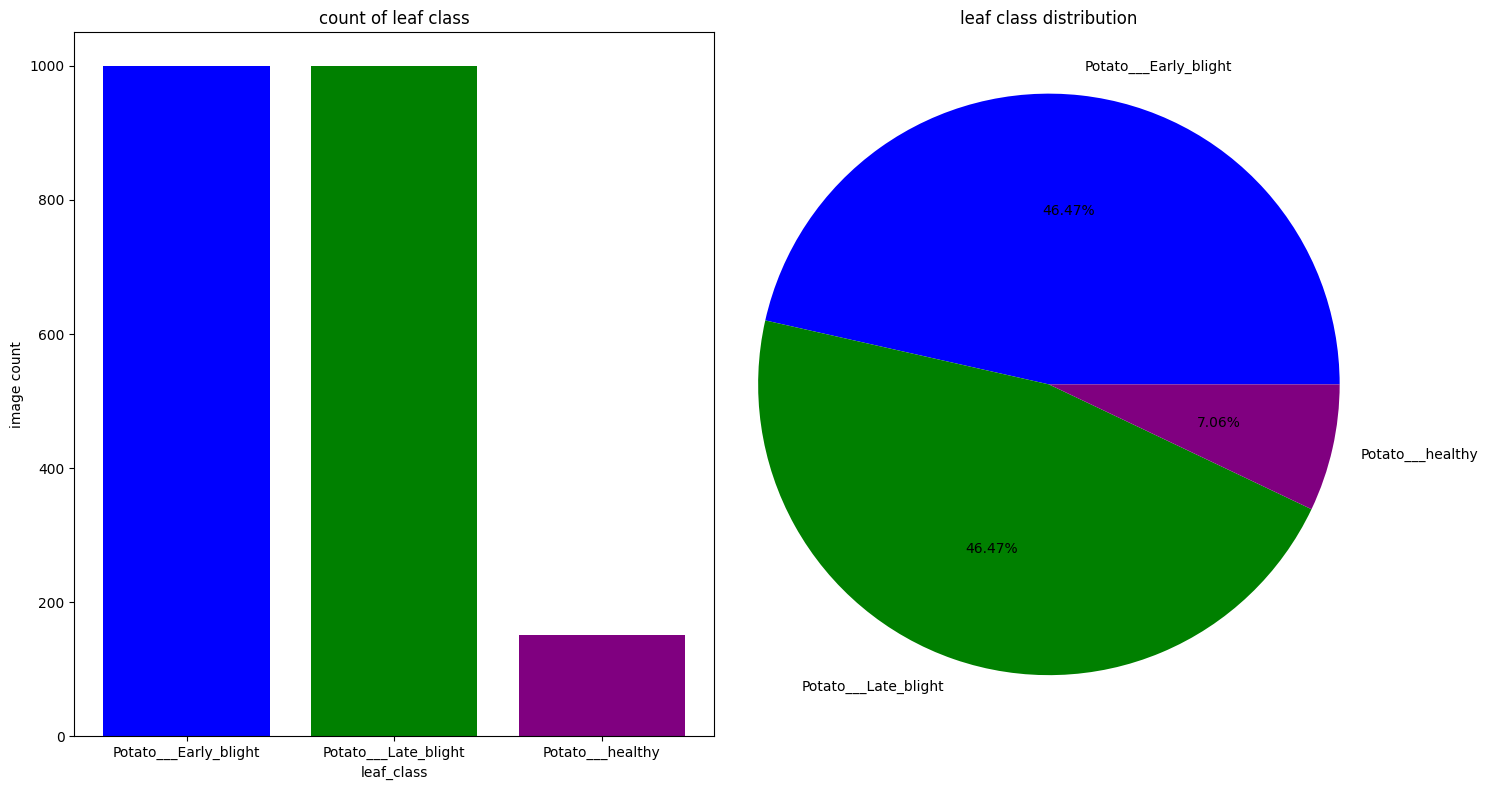

In [72]:
fig , ax = plt.subplots(1,2,figsize=(15,8))
ax[0].bar(class_names,count,color=['blue','green','purple'])
ax[0].set_xlabel('leaf_class')
ax[0].set_ylabel('image count')
ax[0].set_title('count of leaf class')
ax[1].pie(count,labels=class_names,colors = ['blue','green','purple'],autopct='%0.2f%%')
ax[1].set_title('leaf class distribution')
ax[1].axis('equal')

plt.tight_layout()
plt.show()

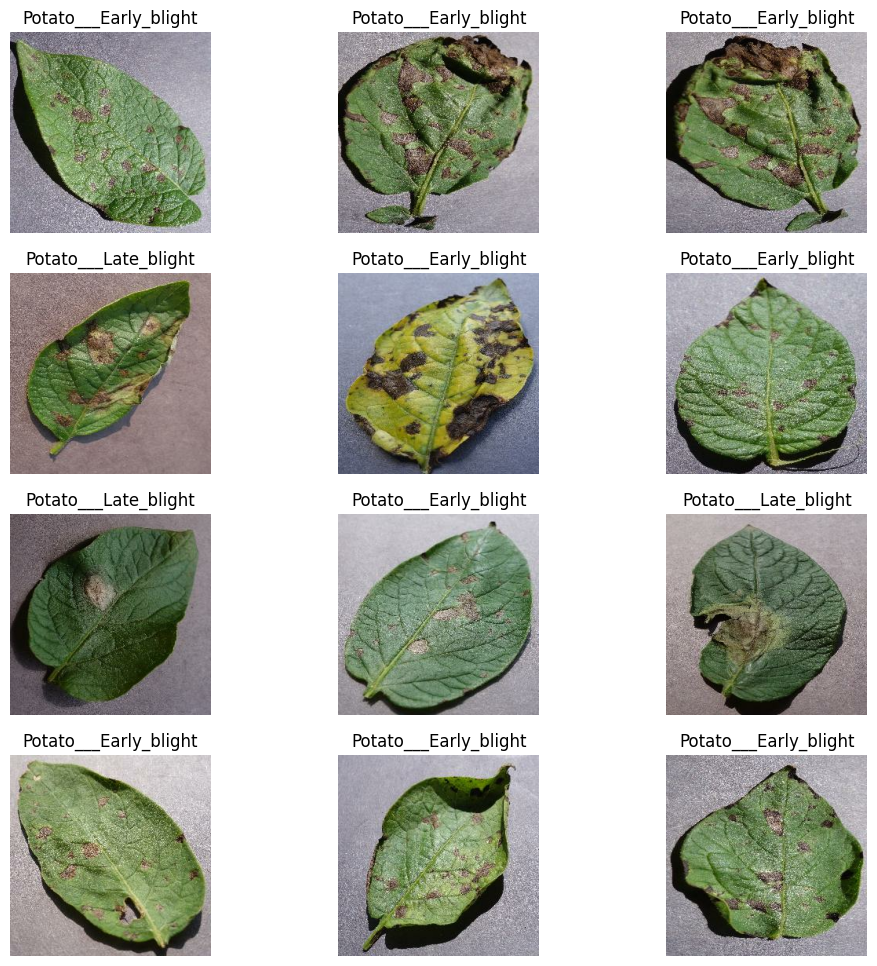

In [73]:
plt.figure(figsize=(12,12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

plt.savefig('plot1.jpg')

In [74]:
len(dataset)

68

In [75]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [76]:
train_ds = dataset.take(54)
len(train_ds)

54

In [77]:
test_ds  = dataset.skip(54)
len(test_ds)

14

In [78]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [79]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [80]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [81]:
def get_data_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+test_split+val_split)==1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [82]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

In [83]:
len(train_ds)

54

In [84]:
len(val_ds)

6

In [85]:
len(test_ds)

8

In [86]:
import torch
import torch.nn as nn
import torch.optim as option
import torch.utils.data as data

In [87]:
# caching,shuffle and prefetching the data
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [88]:
resize_and_rescale = Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [89]:
resize_and_rescale

In [90]:
data_augementation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

In [91]:
model = Sequential()
model.add(resize_and_rescale)
# model.add(data_augementation)
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 60, 60, 128)        

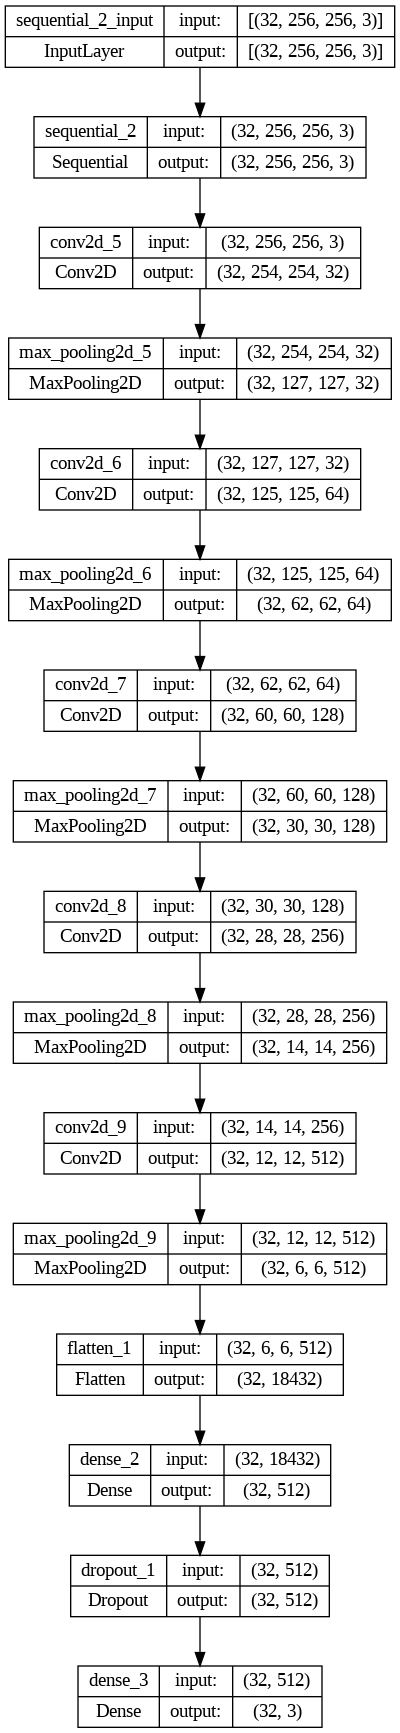

In [93]:
from keras.utils import plot_model
plot_model(model,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [94]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [95]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',patience=10,min_delta=0.001,mode='max',verbose=1)

In [96]:
history = model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=50,callbacks=early_stopping)

Epoch 1/50
54/54 [==============================] - 10s 122ms/step - loss: 0.9070 - accuracy: 0.5463 - val_loss: 0.7206 - val_accuracy: 0.6979
Epoch 2/50
54/54 [==============================] - 4s 72ms/step - loss: 0.5914 - accuracy: 0.7755 - val_loss: 0.4754 - val_accuracy: 0.8333
Epoch 3/50
54/54 [==============================] - 4s 72ms/step - loss: 0.4666 - accuracy: 0.8270 - val_loss: 0.3973 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 4s 72ms/step - loss: 0.3519 - accuracy: 0.8709 - val_loss: 0.3274 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 4s 71ms/step - loss: 0.3044 - accuracy: 0.8872 - val_loss: 0.4944 - val_accuracy: 0.7865
Epoch 6/50
54/54 [==============================] - 4s 71ms/step - loss: 0.3564 - accuracy: 0.8681 - val_loss: 0.2781 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 4s 74ms/step - loss: 0.2991 - accuracy: 0.8889 - val_loss: 0.3085 - val_accuracy: 0.8906
Epoch 8/50


In [97]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 31ms/step - loss: 0.0587 - accuracy: 0.9922


In [98]:
scores

[0.058690011501312256, 0.9921875]

In [99]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [100]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Training and validation Loss')

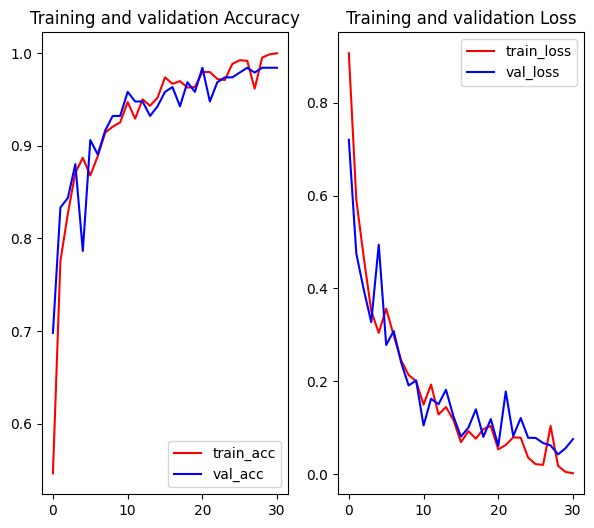

In [101]:
plt.figure(figsize=(7,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],color='red',label='train_acc')
plt.plot(history.history['val_accuracy'],color='blue',label='val_acc')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'],color='red',label='train_loss')
plt.plot(history.history['val_loss'],color='blue',label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and validation Loss')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 171ms/step
predicted label: Potato___Late_blight


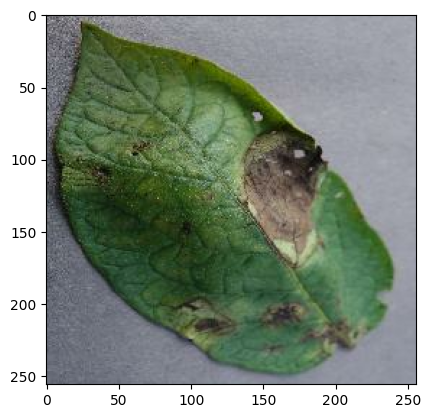

In [102]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])
plt.savefig('plot2.jpg')

In [103]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


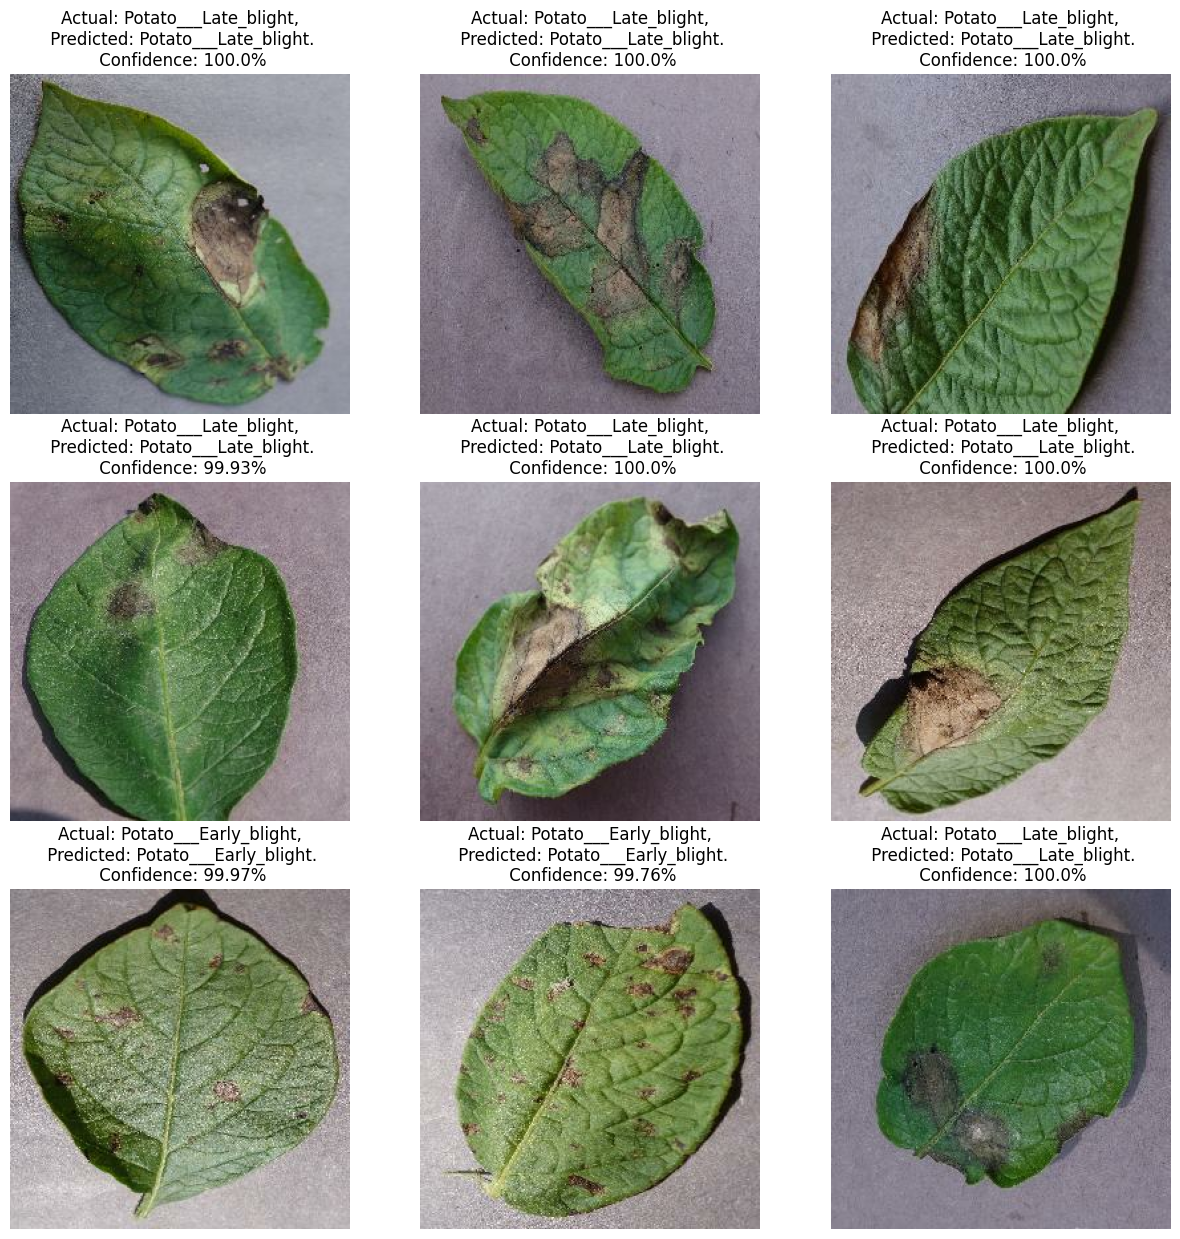

In [104]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
plt.savefig('plot3.jpg')


In [105]:
y_predd = []
y_test = []

for images, labels in test_ds:
    for i in range(32):
      img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
      img_array = tf.expand_dims(img_array, 0)

      predictions = model.predict(img_array)
      y_predd.append(np.argmax(predictions))
      y_test.append(labels[i])

1/1 [==============================] - 0s 19ms/step


In [106]:
print(f"type of y_predd: {type(y_predd)}")
print(f"type of y_test: {type(y_test)}")
print(f"y_predd: {len(y_predd)}")
print(f"y_test: {len(y_test)}")

type of y_predd: <class 'list'>
type of y_test: <class 'list'>
y_predd: 256
y_test: 256


In [107]:
y_pred = np.asarray(y_predd)
y_test = np.asarray(y_test)
print(f"type of y_pred: {type(y_pred)}")
print(f"type of y_test: {type(y_test)}")
print(f"y_pred shape: {y_pred.shape}")
print(f"y_test shape: {y_test.shape}")

type of y_pred: <class 'numpy.ndarray'>
type of y_test: <class 'numpy.ndarray'>
y_pred shape: (256,)
y_test shape: (256,)


In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
#Convert predictions from probabilities to class labels
#y_pred = np.argmax(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC:", mcc)


Accuracy: 0.9921875
Precision: 0.9922226914414414
Recall: 0.9921875
F1 Score: 0.9921405340982546
MCC: 0.9860547672146205


In [109]:
print("Confusion Matrix:")
print(conf)

Confusion Matrix:
[[110   0   0]
 [  1 127   0]
 [  0   1  17]]


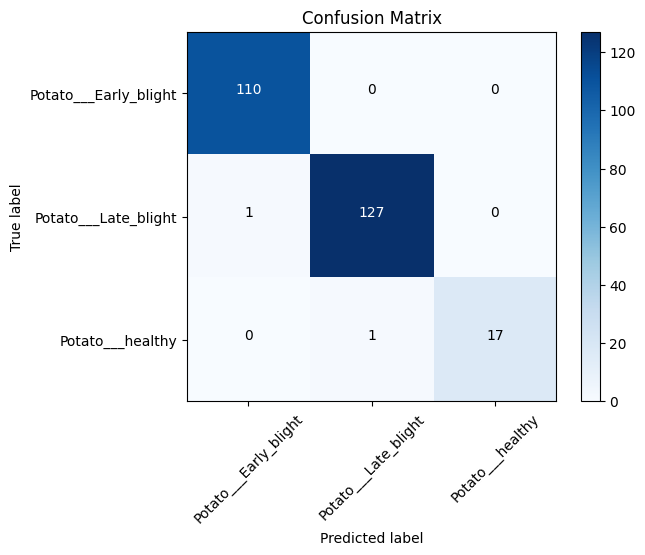

In [110]:
#Plot Confusion Matrix
plt.imshow(conf, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
thresh = conf.max()/2.0
for i,j in np.ndindex(conf.shape):
    plt.text(j,i,format(conf[i,j],'d'),
             horizontalalignment='center',
             color='white' if conf[i,j]>thresh else 'black')

plt.savefig('plot4.jpg')
plt.show()
